In [ ]:
# ============================================
# COMPLETE VISA PREDICTION MODEL
# ============================================

# 1. IMPORT ALL REQUIRED LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, precision_recall_curve, 
                           f1_score, precision_score, recall_score, log_loss)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
plt.style.use('ggplot')
sns.set_palette("husl")

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


In [ ]:

# ============================================
# 2. DATA LOADING AND INITIAL EXPLORATION
# ============================================

# Load your dataset (UPDATE WITH YOUR FILE PATH)
df = pd.read_csv('EasyVisa.csv')  # Change this to your actual file

print("="*60)
print("DATASET OVERVIEW")
print("="*60)
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nData types:")
print(df.dtypes)
print(f"\nMissing values:")
print(df.isnull().sum())
print(f"\nBasic statistics:")
print(df.describe(include='all'))

DATASET OVERVIEW
Dataset shape: (25480, 12)

Columns: ['case_id', 'continent', 'education_of_employee', 'has_job_experience', 'requires_job_training', 'no_of_employees', 'yr_of_estab', 'region_of_employment', 'prevailing_wage', 'unit_of_wage', 'full_time_position', 'case_status']

First 5 rows:
  case_id continent education_of_employee has_job_experience requires_job_training  no_of_employees  yr_of_estab region_of_employment  prevailing_wage unit_of_wage full_time_position case_status
0  EZYV01      Asia           High School                  N                     N            14513         2007                 West         592.2029         Hour                  Y      Denied
1  EZYV02      Asia              Master's                  Y                     N             2412         2002            Northeast       83425.6500         Year                  Y   Certified
2  EZYV03      Asia            Bachelor's                  N                     Y            44444         2008       

In [ ]:

# ============================================
# 3. DATA PREPROCESSING & CLEANING
# ============================================

def clean_and_preprocess(df):
    """Clean and preprocess the visa dataset"""
    
    # Create a copy
    data = df.copy()
    
    # 1. Drop case_id as it's just an identifier
    if 'case_id' in data.columns:
        data = data.drop('case_id', axis=1)
    
    # 2. Check for missing values
    print("\n🔍 Checking for missing values...")
    missing = data.isnull().sum()
    missing_pct = (missing / len(data)) * 100
    missing_df = pd.DataFrame({'Missing_Count': missing, 'Percentage': missing_pct})
    print(missing_df[missing_df['Missing_Count'] > 0])
    
    # 3. Handle missing values
    # For categorical columns, fill with mode
    categorical_cols = data.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if data[col].isnull().sum() > 0:
            mode_val = data[col].mode()[0]
            data[col] = data[col].fillna(mode_val)
            print(f"Filled missing values in {col} with: {mode_val}")
    
    # For numerical columns, fill with median
    numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
    for col in numerical_cols:
        if data[col].isnull().sum() > 0:
            median_val = data[col].median()
            data[col] = data[col].fillna(median_val)
            print(f"Filled missing values in {col} with median: {median_val}")
    
    # 4. Convert binary columns to numeric
    binary_cols = ['has_job_experience', 'requires_job_training', 'full_time_position']
    for col in binary_cols:
        if col in data.columns:
            data[col] = data[col].map({'Y': 1, 'N': 0, 'Yes': 1, 'No': 0, 'yes': 1, 'no': 0})
            # Handle any other values
            data[col] = data[col].apply(lambda x: 1 if str(x).lower() in ['y', 'yes', '1', 'true'] else 0)
    
    # 5. Standardize wage units to annual
    print("\n💰 Standardizing wage units...")
    if 'unit_of_wage' in data.columns and 'prevailing_wage' in data.columns:
        wage_multipliers = {
            'Year': 1,
            'Hour': 2080,  # Assuming 40 hours/week * 52 weeks
            'Month': 12,
            'Week': 52,
            'year': 1,
            'hour': 2080,
            'month': 12,
            'week': 52
        }
        
        # Convert all wages to annual
        data['annual_wage'] = data.apply(
            lambda row: row['prevailing_wage'] * wage_multipliers.get(str(row['unit_of_wage']).lower(), 1), 
            axis=1
        )
        print(f"Created 'annual_wage' column")
        
        # Create wage categories for analysis
        data['wage_category'] = pd.cut(data['annual_wage'], 
                                     bins=[0, 50000, 80000, 120000, 200000, float('inf')],
                                     labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])
    
    # 6. Create company size categories
    if 'no_of_employees' in data.columns:
        data['company_size'] = pd.cut(data['no_of_employees'],
                                    bins=[0, 50, 250, 1000, 5000, float('inf')],
                                    labels=['Micro', 'Small', 'Medium', 'Large', 'Enterprise'])
    
    # 7. Create company age
    if 'yr_of_estab' in data.columns:
        current_year = 2024
        data['company_age'] = current_year - data['yr_of_estab']
        data['company_age'] = data['company_age'].apply(lambda x: max(0, x))  # Ensure non-negative
    
    # 8. Encode target variable
    if 'case_status' in data.columns:
        # Map to binary
        status_mapping = {'Certified': 1, 'Denied': 0, 'certified': 1, 'denied': 0, 
                         'Approved': 1, 'Denied/Withdrawn': 0}
        data['target'] = data['case_status'].map(status_mapping)
        # For any unmapped values, use custom mapping
        data['target'] = data['target'].fillna(data['case_status'].apply(
            lambda x: 1 if str(x).lower() in ['certified', 'approved', 'yes', 'y', '1'] else 0
        ))
        print(f"\n🎯 Target distribution:")
        print(data['target'].value_counts())
        print(f"Approval rate: {data['target'].mean():.2%}")
    
    return data

# Apply preprocessing
df_clean = clean_and_preprocess(df)
print(f"\n✅ Preprocessing complete! Clean dataset shape: {df_clean.shape}")


🔍 Checking for missing values...
Empty DataFrame
Columns: [Missing_Count, Percentage]
Index: []

💰 Standardizing wage units...
Created 'annual_wage' column

🎯 Target distribution:
target
1    17018
0     8462
Name: count, dtype: int64
Approval rate: 66.79%

✅ Preprocessing complete! Clean dataset shape: (25480, 16)



EXPLORATORY DATA ANALYSIS


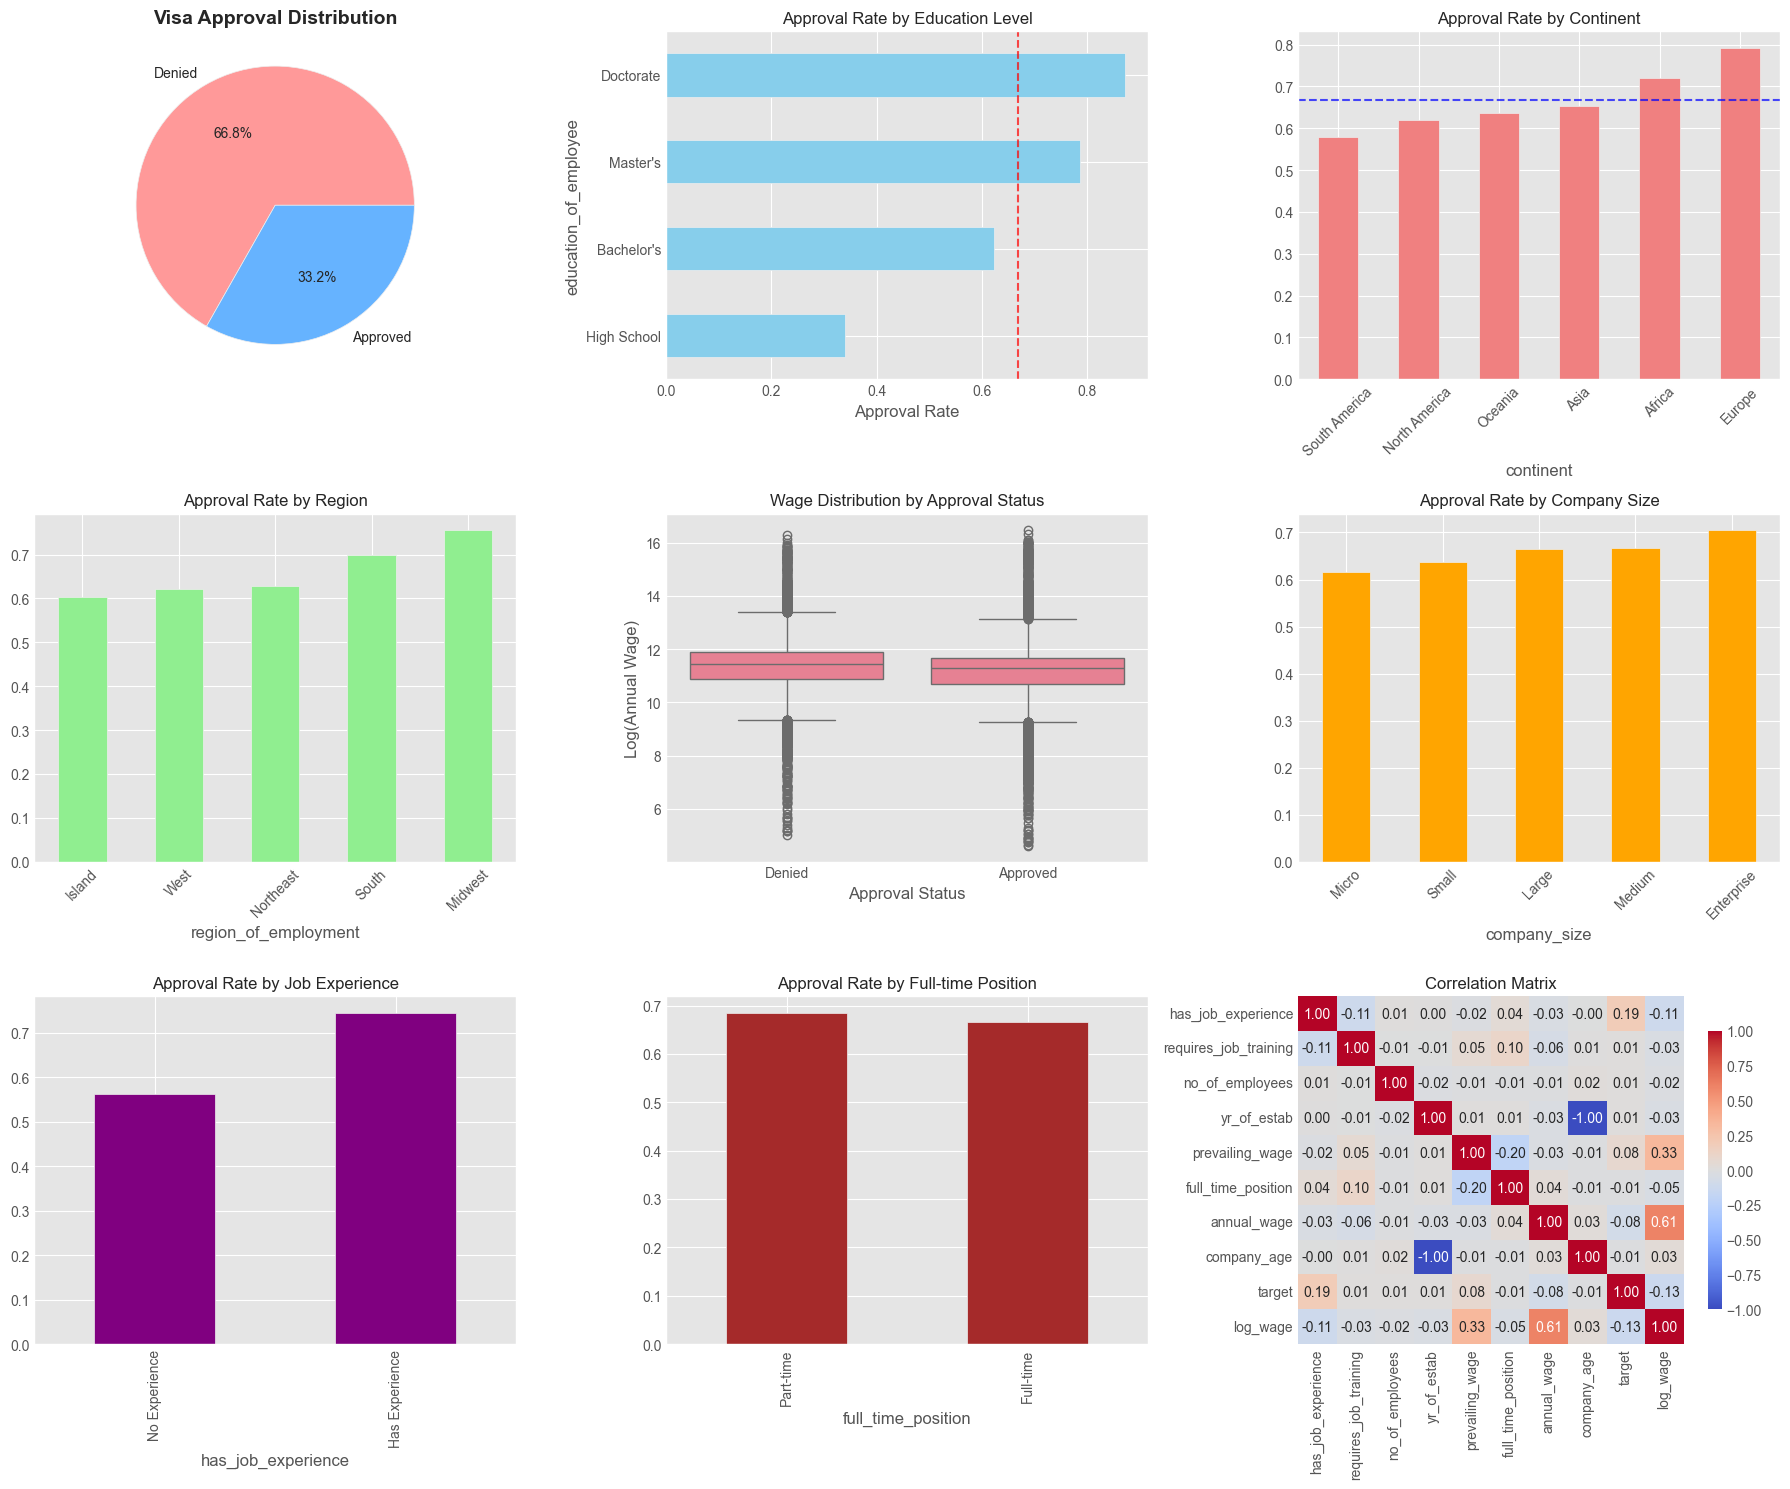


📊 KEY INSIGHTS:
----------------------------------------
Median wage (Approved): $79,377
Median wage (Denied): $91,827
Wage premium for approval: $-12,450
Median company age (Approved): 27.0 years
Median company age (Denied): 27.0 years
Median company size (Approved): 2,147 employees
Median company size (Denied): 2,032 employees


In [ ]:

# ============================================
# 4. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================

def perform_eda(df_clean):
    """Perform comprehensive exploratory data analysis"""
    
    print("\n" + "="*60)
    print("EXPLORATORY DATA ANALYSIS")
    print("="*60)
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.flatten()
    
    # 1. Target Distribution
    target_counts = df_clean['target'].value_counts()
    axes[0].pie(target_counts.values, labels=['Denied', 'Approved'], 
                autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
    axes[0].set_title('Visa Approval Distribution', fontsize=14, fontweight='bold')
    
    # 2. Education vs Approval
    if 'education_of_employee' in df_clean.columns:
        edu_approval = df_clean.groupby('education_of_employee')['target'].mean().sort_values()
        edu_approval.plot(kind='barh', ax=axes[1], color='skyblue')
        axes[1].set_title('Approval Rate by Education Level', fontsize=12)
        axes[1].set_xlabel('Approval Rate')
        axes[1].axvline(df_clean['target'].mean(), color='red', linestyle='--', alpha=0.7)
    
    # 3. Continent Analysis
    if 'continent' in df_clean.columns:
        cont_approval = df_clean.groupby('continent')['target'].mean().sort_values()
        cont_approval.plot(kind='bar', ax=axes[2], color='lightcoral')
        axes[2].set_title('Approval Rate by Continent', fontsize=12)
        axes[2].tick_params(axis='x', rotation=45)
        axes[2].axhline(df_clean['target'].mean(), color='blue', linestyle='--', alpha=0.7)
    
    # 4. Region Analysis
    if 'region_of_employment' in df_clean.columns:
        region_approval = df_clean.groupby('region_of_employment')['target'].mean().sort_values()
        region_approval.plot(kind='bar', ax=axes[3], color='lightgreen')
        axes[3].set_title('Approval Rate by Region', fontsize=12)
        axes[3].tick_params(axis='x', rotation=45)
    
    # 5. Wage vs Approval
    if 'annual_wage' in df_clean.columns:
        df_clean['log_wage'] = np.log1p(df_clean['annual_wage'])
        sns.boxplot(x='target', y='log_wage', data=df_clean, ax=axes[4])
        axes[4].set_title('Wage Distribution by Approval Status', fontsize=12)
        axes[4].set_xlabel('Approval Status')
        axes[4].set_ylabel('Log(Annual Wage)')
        axes[4].set_xticklabels(['Denied', 'Approved'])
    
    # 6. Company Size Impact
    if 'company_size' in df_clean.columns:
        size_approval = df_clean.groupby('company_size')['target'].mean().sort_values()
        size_approval.plot(kind='bar', ax=axes[5], color='orange')
        axes[5].set_title('Approval Rate by Company Size', fontsize=12)
        axes[5].tick_params(axis='x', rotation=45)
    
    # 7. Experience Impact
    if 'has_job_experience' in df_clean.columns:
        exp_approval = df_clean.groupby('has_job_experience')['target'].mean()
        exp_approval.plot(kind='bar', ax=axes[6], color='purple')
        axes[6].set_title('Approval Rate by Job Experience', fontsize=12)
        axes[6].set_xticklabels(['No Experience', 'Has Experience'])
    
    # 8. Full-time Position Impact
    if 'full_time_position' in df_clean.columns:
        ft_approval = df_clean.groupby('full_time_position')['target'].mean()
        ft_approval.plot(kind='bar', ax=axes[7], color='brown')
        axes[7].set_title('Approval Rate by Full-time Position', fontsize=12)
        axes[7].set_xticklabels(['Part-time', 'Full-time'])
    
    # 9. Correlation Heatmap (numerical features only)
    numerical_features = df_clean.select_dtypes(include=[np.number]).columns
    if len(numerical_features) > 1:
        corr_matrix = df_clean[numerical_features].corr()
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
                   center=0, ax=axes[8], cbar_kws={'shrink': 0.8})
        axes[8].set_title('Correlation Matrix', fontsize=12)
    
    plt.tight_layout()
    plt.show()
    
    # Additional insights
    print("\n📊 KEY INSIGHTS:")
    print("-" * 40)
    
    # Calculate key metrics
    if 'annual_wage' in df_clean.columns:
        approved_wage = df_clean[df_clean['target'] == 1]['annual_wage'].median()
        denied_wage = df_clean[df_clean['target'] == 0]['annual_wage'].median()
        print(f"Median wage (Approved): ${approved_wage:,.0f}")
        print(f"Median wage (Denied): ${denied_wage:,.0f}")
        print(f"Wage premium for approval: ${(approved_wage - denied_wage):,.0f}")
    
    if 'company_age' in df_clean.columns:
        age_approved = df_clean[df_clean['target'] == 1]['company_age'].median()
        age_denied = df_clean[df_clean['target'] == 0]['company_age'].median()
        print(f"Median company age (Approved): {age_approved:.1f} years")
        print(f"Median company age (Denied): {age_denied:.1f} years")
    
    if 'no_of_employees' in df_clean.columns:
        emp_approved = df_clean[df_clean['target'] == 1]['no_of_employees'].median()
        emp_denied = df_clean[df_clean['target'] == 0]['no_of_employees'].median()
        print(f"Median company size (Approved): {emp_approved:,.0f} employees")
        print(f"Median company size (Denied): {emp_denied:,.0f} employees")

# Run EDA
perform_eda(df_clean)


In [ ]:
# ============================================
# 5. FEATURE ENGINEERING
# ============================================

def feature_engineering(df_clean):
    """Create additional features for better prediction"""
    
    data = df_clean.copy()
    
    print("\n🔧 Creating additional features...")
    
    # 1. Create wage percentiles
    if 'annual_wage' in data.columns:
        data['wage_percentile'] = pd.qcut(data['annual_wage'], q=10, labels=False, duplicates='drop')
        data['wage_to_median_ratio'] = data['annual_wage'] / data['annual_wage'].median()
    
    # 2. Create education score (numeric representation)
    if 'education_of_employee' in data.columns:
        education_scores = {
            'High School': 1,
            'Bachelor\'s': 2,
            'Master\'s': 3,
            'Doctorate': 4,
            'PhD': 4,
            'Associate': 1.5,
            'Professional': 2.5
        }
        data['education_score'] = data['education_of_employee'].map(education_scores).fillna(1)
    
    # 3. Create risk score based on multiple factors
    risk_score = 0
    
    # Lower education = higher risk
    if 'education_score' in data.columns:
        risk_score += (5 - data['education_score']) * 0.2
    
    # No experience = higher risk
    if 'has_job_experience' in data.columns:
        risk_score += (1 - data['has_job_experience']) * 0.3
    
    # Part-time = higher risk
    if 'full_time_position' in data.columns:
        risk_score += (1 - data['full_time_position']) * 0.2
    
    # Smaller company = higher risk
    if 'no_of_employees' in data.columns:
        data['company_size_score'] = np.log1p(data['no_of_employees']) / np.log1p(data['no_of_employees'].max())
        risk_score += (1 - data['company_size_score']) * 0.2
    
    # Lower wage = higher risk
    if 'wage_to_median_ratio' in data.columns:
        risk_score += (1 - np.minimum(data['wage_to_median_ratio'], 1)) * 0.1
    
    data['risk_score'] = risk_score
    
    # 4. Create interaction features
    if all(col in data.columns for col in ['education_score', 'annual_wage']):
        data['edu_wage_interaction'] = data['education_score'] * np.log1p(data['annual_wage'])
    
    if all(col in data.columns for col in ['has_job_experience', 'full_time_position']):
        data['exp_ft_interaction'] = data['has_job_experience'] * data['full_time_position']
    
    print(f"✅ Created {len(data.columns) - len(df_clean.columns)} new features")
    print(f"Total features now: {len(data.columns)}")
    
    return data

# Apply feature engineering
df_features = feature_engineering(df_clean)



🔧 Creating additional features...
✅ Created 7 new features
Total features now: 24


In [ ]:
# ============================================
# 6. DATA PREPARATION FOR MODELING (FIXED)
# ============================================

def prepare_data_for_modeling(df_features):
    """Prepare final dataset for modeling - fixed for duplicate columns"""
    
    # Create a copy to avoid modifying original
    data = df_features.copy()
    
    # Define target column
    target_col = 'target'
    
    print("\n🔍 Checking for duplicate columns...")
    # Identify duplicate column names
    duplicate_cols = data.columns[data.columns.duplicated()].tolist()
    if duplicate_cols:
        print(f"Found duplicate columns: {duplicate_cols}")
        # Remove duplicates, keep first occurrence
        data = data.loc[:, ~data.columns.duplicated()]
    
    # First, let's identify what columns we actually have
    print(f"\nAvailable columns after cleaning ({len(data.columns)} total):")
    for i, col in enumerate(data.columns):
        print(f"{i+1:3d}. {col}: {data[col].dtype}")
    
    # Define feature groups based on actual columns
    categorical_cols = []
    numerical_cols = []
    binary_cols = []
    
    # Identify categorical columns
    cat_candidates = ['continent', 'education_of_employee', 'region_of_employment', 
                     'unit_of_wage', 'company_size', 'wage_category']
    for col in cat_candidates:
        if col in data.columns:
            categorical_cols.append(col)
    
    # Identify binary columns (should be numeric 0/1 after preprocessing)
    bin_candidates = ['has_job_experience', 'requires_job_training', 'full_time_position']
    for col in bin_candidates:
        if col in data.columns:
            binary_cols.append(col)
    
    # Identify numerical columns - all remaining numeric columns except target
    for col in data.columns:
        if col not in categorical_cols + binary_cols + [target_col, 'case_status']:
            if pd.api.types.is_numeric_dtype(data[col]):
                numerical_cols.append(col)
    
    # Let's check what we've identified
    print(f"\n📋 Features identified for modeling:")
    print(f"Categorical ({len(categorical_cols)}): {categorical_cols}")
    print(f"Numerical ({len(numerical_cols)}): {numerical_cols}")
    print(f"Binary ({len(binary_cols)}): {binary_cols}")
    
    # Verify all columns exist
    all_features = categorical_cols + numerical_cols + binary_cols
    missing_cols = [col for col in all_features if col not in data.columns]
    if missing_cols:
        print(f"\n⚠️ Warning: Some columns not found in dataframe: {missing_cols}")
        # Remove missing columns
        all_features = [col for col in all_features if col in data.columns]
        categorical_cols = [col for col in categorical_cols if col in data.columns]
        numerical_cols = [col for col in numerical_cols if col in data.columns]
        binary_cols = [col for col in binary_cols if col in data.columns]
    
    # Create X and y
    X = data[all_features]
    y = data[target_col]
    
    print(f"\n✅ Data prepared for modeling")
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    print(f"Total features: {len(all_features)}")
    print(f"Approval rate: {y.mean():.2%}")
    
    # Show sample of X
    print(f"\n📊 Sample of features:")
    print(X.head())
    
    return X, y, categorical_cols, numerical_cols, binary_cols

# Prepare data with the fixed function
X, y, cat_cols, num_cols, bin_cols = prepare_data_for_modeling(df_features)


🔍 Checking for duplicate columns...

Available columns after cleaning (24 total):
  1. continent: object
  2. education_of_employee: object
  3. has_job_experience: int64
  4. requires_job_training: int64
  5. no_of_employees: int64
  6. yr_of_estab: int64
  7. region_of_employment: object
  8. prevailing_wage: float64
  9. unit_of_wage: object
 10. full_time_position: int64
 11. case_status: object
 12. annual_wage: float64
 13. wage_category: category
 14. company_size: category
 15. company_age: int64
 16. target: int64
 17. log_wage: float64
 18. wage_percentile: int64
 19. wage_to_median_ratio: float64
 20. education_score: float64
 21. company_size_score: float64
 22. risk_score: float64
 23. edu_wage_interaction: float64
 24. exp_ft_interaction: int64

📋 Features identified for modeling:
Categorical (6): ['continent', 'education_of_employee', 'region_of_employment', 'unit_of_wage', 'company_size', 'wage_category']
Numerical (13): ['no_of_employees', 'yr_of_estab', 'prevailing_w

In [ ]:
# ============================================
# 7. CREATE PREPROCESSING PIPELINE
# ============================================

def create_preprocessing_pipeline(categorical_cols, numerical_cols, binary_cols):
    """Create preprocessing pipeline for different feature types"""
    
    print("\n🛠️ Creating preprocessing pipeline...")
    
    # Numerical pipeline
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
    
    # Categorical pipeline
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    # Binary pipeline (already encoded as 0/1)
    binary_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent'))
    ])
    
    # Combine all transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_cols),
            ('cat', categorical_transformer, categorical_cols),
            ('bin', binary_transformer, binary_cols)
        ]
    )
    
    return preprocessor

# Create preprocessor
preprocessor = create_preprocessing_pipeline(cat_cols, num_cols, bin_cols)


🛠️ Creating preprocessing pipeline...


In [ ]:

# ============================================
# 8. MODEL TRAINING AND EVALUATION
# ============================================

def train_and_evaluate_models(X, y, preprocessor):
    """Train multiple models and compare performance"""
    
    print("\n" + "="*60)
    print("MODEL TRAINING AND EVALUATION")
    print("="*60)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")
    print(f"Training approval rate: {y_train.mean():.2%}")
    print(f"Test approval rate: {y_test.mean():.2%}")
    
    # Define models
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced'),
        'XGBoost': XGBClassifier(random_state=42, n_jobs=-1, eval_metric='logloss',
                                scale_pos_weight=(len(y_train) - sum(y_train)) / sum(y_train)),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42),
        'LightGBM': LGBMClassifier(random_state=42, n_jobs=-1, class_weight='balanced')
    }
    
    results = {}
    
    for model_name, model in models.items():
        print(f"\n🔍 Training {model_name}...")
        
        # Create pipeline with SMOTE for handling imbalance
        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),
            ('classifier', model)
        ])
        
        # Train model
        pipeline.fit(X_train, y_train)
        
        # Make predictions
        y_pred = pipeline.predict(X_test)
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred_proba)
        logloss = log_loss(y_test, y_pred_proba)
        
        # Cross-validation scores
        cv_scores = cross_val_score(pipeline, X_train, y_train, 
                                   cv=StratifiedKFold(n_splits=5), 
                                   scoring='roc_auc', n_jobs=-1)
        
        # Store results
        results[model_name] = {
            'model': pipeline,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'roc_auc': roc_auc,
            'log_loss': logloss,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }
        
        # Print results
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  Precision: {precision:.4f}")
        print(f"  Recall: {recall:.4f}")
        print(f"  F1-Score: {f1:.4f}")
        print(f"  ROC-AUC: {roc_auc:.4f}")
        print(f"  Log Loss: {logloss:.4f}")
        print(f"  CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
    
    return results, X_test, y_test

# Train and evaluate models
results, X_test, y_test = train_and_evaluate_models(X, y, preprocessor)



MODEL TRAINING AND EVALUATION
Training set: (20384, 22)
Test set: (5096, 22)
Training approval rate: 66.79%
Test approval rate: 66.80%

🔍 Training Logistic Regression...
  Accuracy: 0.6892
  Precision: 0.8070
  Recall: 0.7027
  F1-Score: 0.7513
  ROC-AUC: 0.7563
  Log Loss: 0.5871
  CV ROC-AUC: 0.7714 (+/- 0.0103)

🔍 Training Random Forest...
  Accuracy: 0.7111
  Precision: 0.7836
  Recall: 0.7841
  F1-Score: 0.7838
  ROC-AUC: 0.7454
  Log Loss: 0.5698
  CV ROC-AUC: 0.7551 (+/- 0.0134)

🔍 Training XGBoost...
  Accuracy: 0.6858
  Precision: 0.8178
  Recall: 0.6816
  F1-Score: 0.7435
  ROC-AUC: 0.7597
  Log Loss: 0.5892
  CV ROC-AUC: 0.7669 (+/- 0.0121)

🔍 Training Gradient Boosting...
  Accuracy: 0.7263
  Precision: 0.8027
  Recall: 0.7826
  F1-Score: 0.7925
  ROC-AUC: 0.7683
  Log Loss: 0.5471
  CV ROC-AUC: 0.7825 (+/- 0.0104)

🔍 Training LightGBM...
[LightGBM] [Info] Number of positive: 13614, number of negative: 13614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the ove


MODEL COMPARISON

📊 Performance Comparison (sorted by ROC-AUC):
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC  CV ROC-AUC  Log Loss
           LightGBM  0.742543   0.788950 0.839013  0.813212 0.771796    0.780301  0.529504
  Gradient Boosting  0.726256   0.802651 0.782609  0.792503 0.768310    0.782517  0.547051
            XGBoost  0.685832   0.817765 0.681551  0.743471 0.759701    0.766857  0.589185
Logistic Regression  0.689168   0.807018 0.702703  0.751256 0.756285    0.771444  0.587115
      Random Forest  0.711146   0.783617 0.784078  0.783847 0.745368    0.755093  0.569768


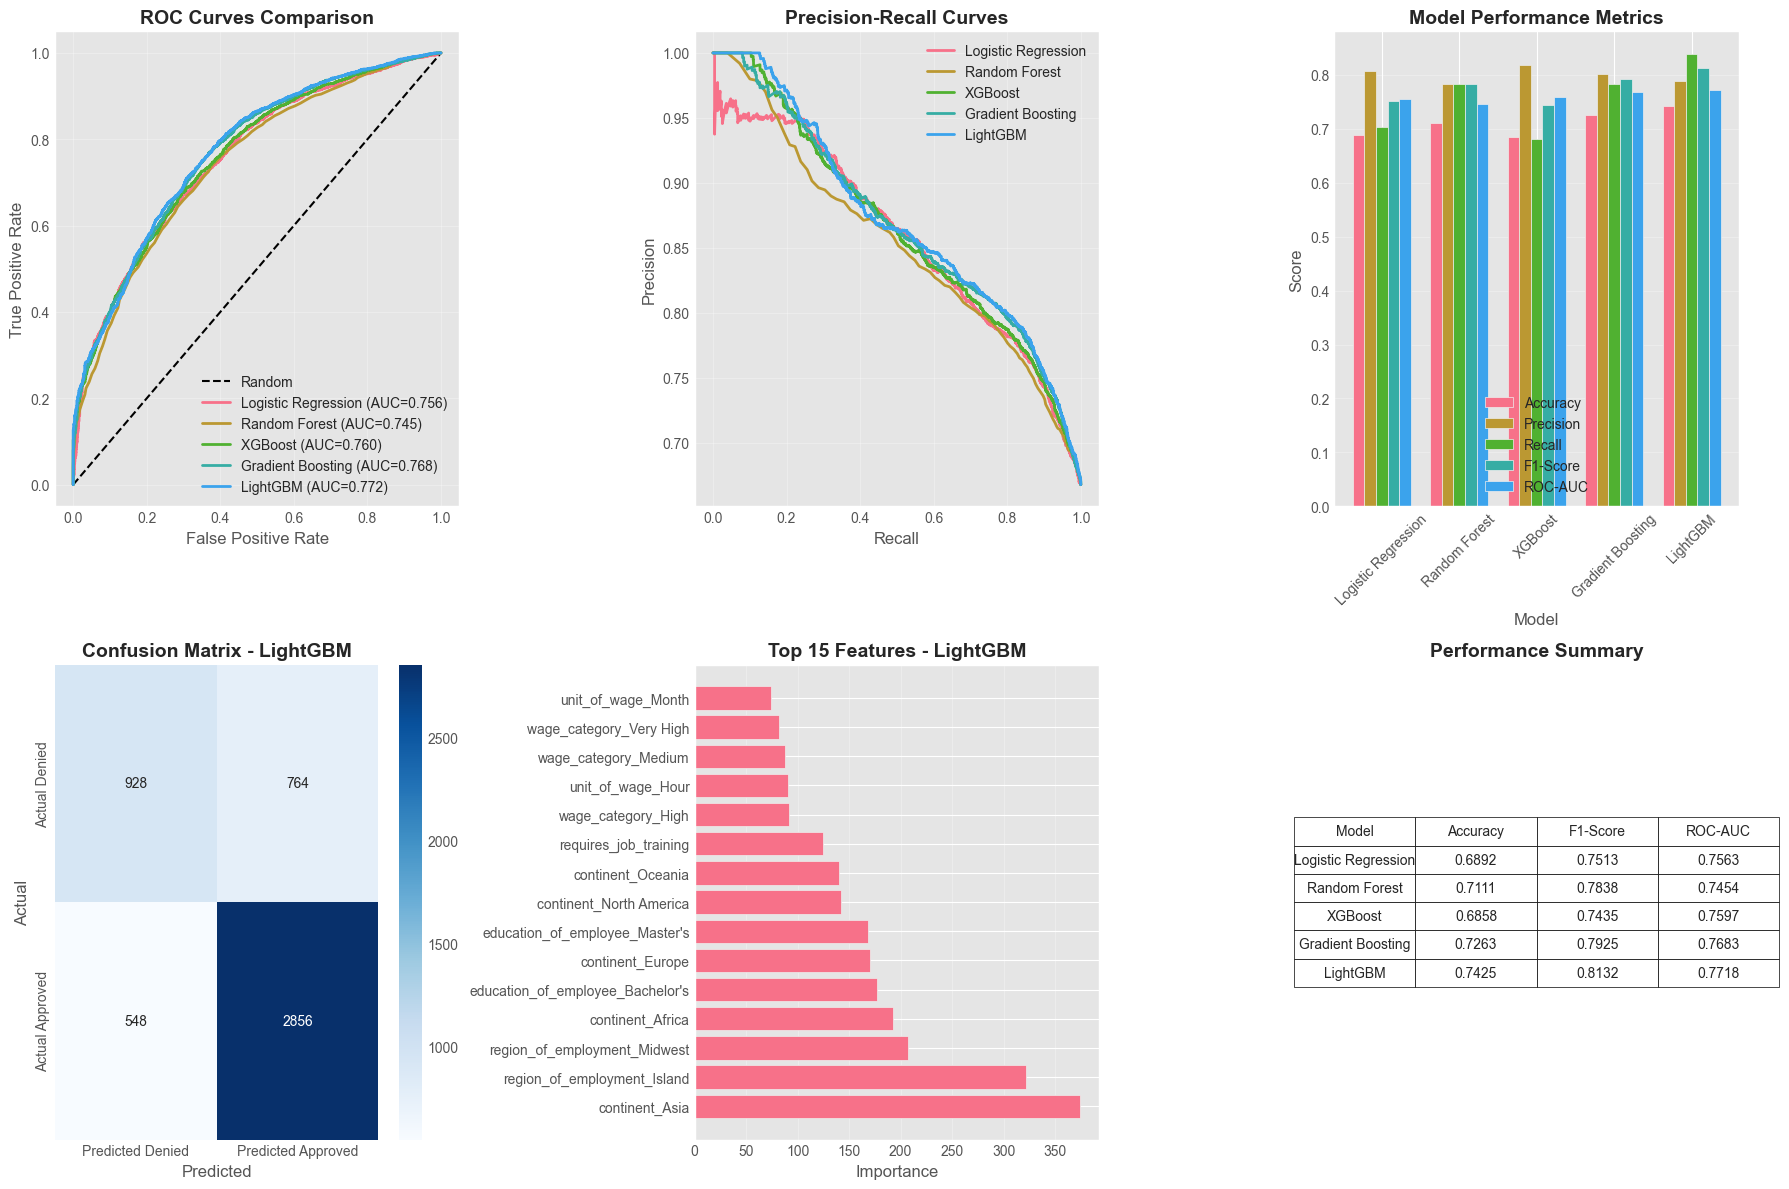


🏆 BEST MODEL: LightGBM
   ROC-AUC: 0.7718
   Accuracy: 0.7425
   F1-Score: 0.8132

📋 Classification Report for Best Model:
              precision    recall  f1-score   support

      Denied       0.63      0.55      0.59      1692
    Approved       0.79      0.84      0.81      3404

    accuracy                           0.74      5096
   macro avg       0.71      0.69      0.70      5096
weighted avg       0.74      0.74      0.74      5096



In [ ]:
# ============================================
# 9. MODEL COMPARISON AND VISUALIZATION
# ============================================

def compare_models(results, y_test):
    """Compare model performance visually"""
    
    print("\n" + "="*60)
    print("MODEL COMPARISON")
    print("="*60)
    
    # Create comparison dataframe
    comparison_data = []
    for model_name, metrics in results.items():
        comparison_data.append({
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1-Score': metrics['f1'],
            'ROC-AUC': metrics['roc_auc'],
            'CV ROC-AUC': metrics['cv_mean'],
            'Log Loss': metrics['log_loss']
        })
    
    comparison_df = pd.DataFrame(comparison_data)
    
    print("\n📊 Performance Comparison (sorted by ROC-AUC):")
    print(comparison_df.sort_values('ROC-AUC', ascending=False).to_string(index=False))
    
    # Visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # 1. ROC Curves
    axes[0].plot([0, 1], [0, 1], 'k--', label='Random')
    for model_name, metrics in results.items():
        fpr, tpr, _ = roc_curve(y_test, metrics['y_pred_proba'])
        axes[0].plot(fpr, tpr, label=f'{model_name} (AUC={metrics["roc_auc"]:.3f})', linewidth=2)
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('ROC Curves Comparison', fontsize=14, fontweight='bold')
    axes[0].legend(loc='lower right')
    axes[0].grid(True, alpha=0.3)
    
    # 2. Precision-Recall Curves
    for model_name, metrics in results.items():
        precision, recall, _ = precision_recall_curve(y_test, metrics['y_pred_proba'])
        axes[1].plot(recall, precision, label=model_name, linewidth=2)
    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')
    axes[1].set_title('Precision-Recall Curves', fontsize=14, fontweight='bold')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    
    # 3. Metric Comparison Bar Chart
    metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
    metric_data = comparison_df.set_index('Model')[metrics_to_plot]
    x = np.arange(len(metric_data))
    width = 0.15
    
    for i, metric in enumerate(metrics_to_plot):
        axes[2].bar(x + i*width, metric_data[metric], width, label=metric)
    
    axes[2].set_xlabel('Model')
    axes[2].set_ylabel('Score')
    axes[2].set_title('Model Performance Metrics', fontsize=14, fontweight='bold')
    axes[2].set_xticks(x + width*2)
    axes[2].set_xticklabels(metric_data.index, rotation=45)
    axes[2].legend()
    axes[2].grid(True, alpha=0.3, axis='y')
    
    # 4. Confusion Matrix for Best Model
    best_model_name = max(results.items(), key=lambda x: x[1]['roc_auc'])[0]
    best_metrics = results[best_model_name]
    cm = confusion_matrix(y_test, best_metrics['y_pred'])
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[3],
                xticklabels=['Predicted Denied', 'Predicted Approved'],
                yticklabels=['Actual Denied', 'Actual Approved'])
    axes[3].set_title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
    axes[3].set_ylabel('Actual')
    axes[3].set_xlabel('Predicted')
    
    # 5. Feature Importance for tree-based models
    try:
        best_model = results[best_model_name]['model']
        if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
            # Get feature names
            feature_names = []
            
            # Get categorical feature names from onehot encoder
            cat_encoder = best_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
            cat_features = cat_encoder.get_feature_names_out(cat_cols)
            feature_names.extend(cat_features)
            
            # Add numerical features
            feature_names.extend(num_cols)
            
            # Add binary features
            feature_names.extend(bin_cols)
            
            # Get importances
            importances = best_model.named_steps['classifier'].feature_importances_
            
            # Create importance dataframe
            importance_df = pd.DataFrame({
                'feature': feature_names[:len(importances)],
                'importance': importances
            }).sort_values('importance', ascending=False).head(15)
            
            # Plot
            axes[4].barh(range(len(importance_df)), importance_df['importance'])
            axes[4].set_yticks(range(len(importance_df)))
            axes[4].set_yticklabels(importance_df['feature'])
            axes[4].set_xlabel('Importance')
            axes[4].set_title(f'Top 15 Features - {best_model_name}', fontsize=14, fontweight='bold')
            axes[4].grid(True, alpha=0.3, axis='x')
    except:
        axes[4].text(0.5, 0.5, 'Feature importance not available\nfor this model type',
                    ha='center', va='center', transform=axes[4].transAxes)
        axes[4].set_title('Feature Importance', fontsize=14, fontweight='bold')
    
    # 6. Model Comparison Table
    axes[5].axis('tight')
    axes[5].axis('off')
    table_data = comparison_df[['Model', 'Accuracy', 'F1-Score', 'ROC-AUC']].round(4).values
    table = axes[5].table(cellText=table_data,
                         colLabels=['Model', 'Accuracy', 'F1-Score', 'ROC-AUC'],
                         loc='center',
                         cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    axes[5].set_title('Performance Summary', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print best model details
    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"   ROC-AUC: {best_metrics['roc_auc']:.4f}")
    print(f"   Accuracy: {best_metrics['accuracy']:.4f}")
    print(f"   F1-Score: {best_metrics['f1']:.4f}")
    
    print("\n📋 Classification Report for Best Model:")
    print(classification_report(y_test, best_metrics['y_pred'], 
                                target_names=['Denied', 'Approved']))
    
    return comparison_df, best_model_name

# Compare models
comparison_df, best_model_name = compare_models(results, y_test)

In [ ]:

# ============================================
# 10. HYPERPARAMETER TUNING
# ============================================

def tune_best_model(X, y, preprocessor, best_model_name, results):
    """Perform hyperparameter tuning on the best model"""
    
    print("\n" + "="*60)
    print("HYPERPARAMETER TUNING")
    print("="*60)
    
    # Get the best model
    best_model = results[best_model_name]['model'].named_steps['classifier']
    
    # Define parameter grids based on model type
    param_grids = {
        'XGBoost': {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [3, 5, 7],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__subsample': [0.8, 0.9, 1.0],
            'classifier__colsample_bytree': [0.8, 0.9, 1.0]
        },
        'Random Forest': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20, 30, None],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4],
            'classifier__bootstrap': [True, False]
        },
        'Logistic Regression': {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'classifier__penalty': ['l1', 'l2', 'elasticnet'],
            'classifier__solver': ['liblinear', 'saga']
        },
        'Gradient Boosting': {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__max_depth': [3, 5, 7],
            'classifier__min_samples_split': [2, 5],
            'classifier__min_samples_leaf': [1, 2, 4]
        },
        'LightGBM': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [3, 5, 7, -1],
            'classifier__learning_rate': [0.01, 0.1, 0.2],
            'classifier__num_leaves': [31, 50, 100],
            'classifier__subsample': [0.8, 0.9, 1.0]
        }
    }
    
    # Get appropriate parameter grid
    param_grid = param_grids.get(best_model_name, {})
    
    if not param_grid:
        print(f"⚠️ No parameter grid defined for {best_model_name}. Skipping tuning.")
        return results[best_model_name]['model']
    
    print(f"Tuning {best_model_name}...")
    
    # Create pipeline for tuning
    pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=42)),
        ('classifier', best_model)
    ])
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Grid search
    grid_search = GridSearchCV(
        pipeline,
        param_grid,
        cv=StratifiedKFold(n_splits=3),
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1
    )
    
    # Fit grid search
    grid_search.fit(X_train, y_train)
    
    print(f"\n✅ Tuning complete!")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")
    
    # Evaluate on validation set
    y_pred = grid_search.predict(X_val)
    y_pred_proba = grid_search.predict_proba(X_val)[:, 1]
    
    print(f"\nValidation Performance:")
    print(f"  Accuracy: {accuracy_score(y_val, y_pred):.4f}")
    print(f"  ROC-AUC: {roc_auc_score(y_val, y_pred_proba):.4f}")
    print(f"  F1-Score: {f1_score(y_val, y_pred):.4f}")
    
    return grid_search.best_estimator_

# Tune the best model
tuned_model = tune_best_model(X, y, preprocessor, best_model_name, results)



HYPERPARAMETER TUNING
Tuning LightGBM...
Fitting 3 folds for each of 216 candidates, totalling 648 fits
[LightGBM] [Info] Number of positive: 13614, number of negative: 13614
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007042 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6387
[LightGBM] [Info] Number of data points in the train set: 27228, number of used features: 45
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000

✅ Tuning complete!
Best parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__num_leaves': 31, 'classifier__subsample': 0.8}
Best CV score: 0.7842

Validation Performance:
  Accuracy: 0.7259
  ROC-AUC: 0.7742
  F1-Score: 0.7915


In [126]:
X_train.columns

Index(['continent', 'education_of_employee', 'has_job_experience', 'unit_of_wage', 'log_prevailing_wage', 'log_no_of_employees', 'log_annual_wage'], dtype='object')